In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
heart_failure_df = pd.read_csv('../data/heart_failure_clinical_records_dataset.csv')
heart_df = pd.read_csv('../data/heart.csv')

In [3]:
print(heart_failure_df.head())
print(heart_df.head())

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

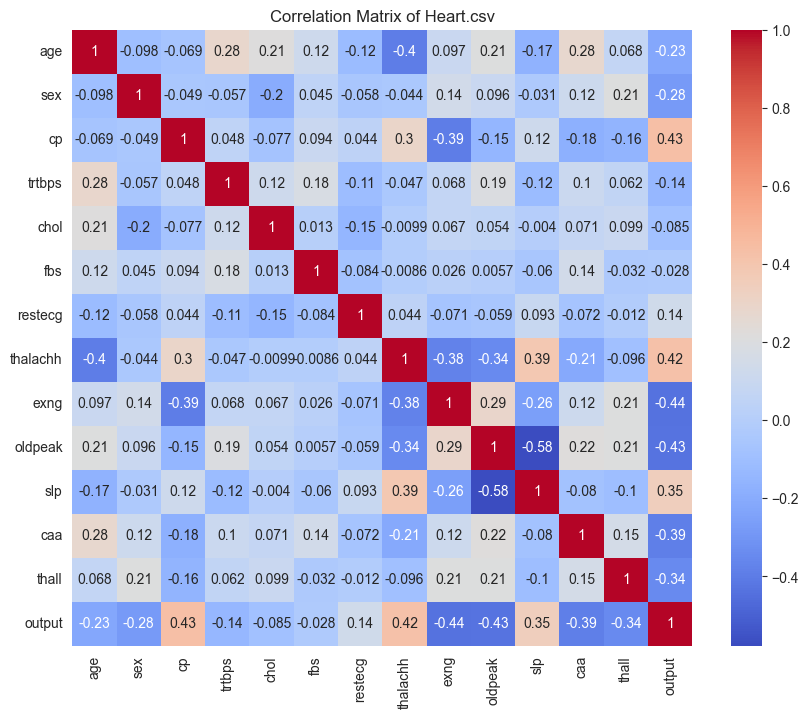

In [4]:
# 2. Аналіз другого датасету для визначення найбільш впливових ознак на таргет колонку 'output'
# Кореляційний аналіз для визначення найбільш впливових ознак
plt.figure(figsize=(10, 8))
sns.heatmap(heart_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Heart.csv')
plt.show()

In [7]:
# Вибір найбільш корельованих ознак з таргет колонкою 'output'
corr_matrix = heart_df.corr()
output_corr = corr_matrix['output'].abs().sort_values(ascending=False)
print("Кореляція з 'output':\n", output_corr)

Кореляція з 'output':
 output      1.000000
exng        0.436757
cp          0.433798
oldpeak     0.430696
thalachh    0.421741
caa         0.391724
slp         0.345877
thall       0.344029
sex         0.280937
age         0.225439
trtbps      0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: output, dtype: float64


In [8]:
# Вибираємо 5 найбільш корельованих ознак, крім 'output' самої
top_features = output_corr.index[1:6].tolist()  # Беремо топ-5 ознак
print("Найбільш важливі ознаки з другого датасету:", top_features)

Найбільш важливі ознаки з другого датасету: ['exng', 'cp', 'oldpeak', 'thalachh', 'caa']


In [9]:
# Вибираємо ці ознаки з другого датасету
heart_df_selected = heart_df[top_features + ['age', 'sex']]

In [20]:
# Перетворення 'age' на int із використанням .loc[] для уникнення SettingWithCopyWarning
heart_failure_df['age'] = heart_failure_df['age'].astype(int)
heart_df_selected.loc[:, 'age'] = heart_df_selected['age'].astype(int)

# Злиття двох датасетів
merged_df = pd.merge(heart_failure_df, heart_df_selected, on=['age', 'sex'], how='inner')
merged_df = merged_df.drop('time', axis=1)
# Перевірка результатів
print(merged_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       1151 non-null   int32  
 1   anaemia                   1151 non-null   int64  
 2   creatinine_phosphokinase  1151 non-null   int64  
 3   diabetes                  1151 non-null   int64  
 4   ejection_fraction         1151 non-null   int64  
 5   high_blood_pressure       1151 non-null   int64  
 6   platelets                 1151 non-null   float64
 7   serum_creatinine          1151 non-null   float64
 8   serum_sodium              1151 non-null   int64  
 9   sex                       1151 non-null   int64  
 10  smoking                   1151 non-null   int64  
 11  DEATH_EVENT               1151 non-null   int64  
 12  exng                      1151 non-null   int64  
 13  cp                        1151 non-null   int64  
 14  oldpeak 

In [21]:
# Огляд об'єднаного датасету
print(merged_df.info())
print(merged_df.head(1151))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       1151 non-null   int32  
 1   anaemia                   1151 non-null   int64  
 2   creatinine_phosphokinase  1151 non-null   int64  
 3   diabetes                  1151 non-null   int64  
 4   ejection_fraction         1151 non-null   int64  
 5   high_blood_pressure       1151 non-null   int64  
 6   platelets                 1151 non-null   float64
 7   serum_creatinine          1151 non-null   float64
 8   serum_sodium              1151 non-null   int64  
 9   sex                       1151 non-null   int64  
 10  smoking                   1151 non-null   int64  
 11  DEATH_EVENT               1151 non-null   int64  
 12  exng                      1151 non-null   int64  
 13  cp                        1151 non-null   int64  
 14  oldpeak 

In [30]:
merged_df.head(100)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT,exng,cp,oldpeak,thalachh,caa
0,55,0,7861,0,38,0,263358.03,1.1,136,1,0,1,0,1,0.0,155,0
1,55,0,7861,0,38,0,263358.03,1.1,136,1,0,1,1,0,1.2,132,1
2,55,0,7861,0,38,0,263358.03,1.1,136,1,0,1,1,0,5.6,111,0
3,55,0,7861,0,38,0,263358.03,1.1,136,1,0,1,1,0,0.8,145,1
4,65,0,146,0,20,0,162000.00,1.3,129,1,1,1,0,0,0.4,140,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,60,0,2656,1,30,0,305000.00,2.3,137,1,0,0,1,0,1.4,144,1
96,60,0,2656,1,30,0,305000.00,2.3,137,1,0,0,1,0,2.8,142,2
97,60,0,2656,1,30,0,305000.00,2.3,137,1,0,0,0,2,3.0,155,0
98,60,0,2656,1,30,0,305000.00,2.3,137,1,0,0,1,0,2.8,141,1


In [29]:
X = merged_df.drop('DEATH_EVENT', axis=1)  # 'DEATH_EVENT' - це таргет колонка у першому датасеті
y = merged_df['DEATH_EVENT']

# Розділяємо дані на тренувальні і тестові набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормалізація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Логістична регресія
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.7662337662337663
Logistic Regression ROC-AUC: 0.583315666737333
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       178
           1       0.48      0.25      0.33        53

    accuracy                           0.77       231
   macro avg       0.64      0.58      0.59       231
weighted avg       0.73      0.77      0.74       231



In [28]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.974025974025974
Random Forest ROC-AUC: 0.9433962264150944
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       178
           1       1.00      0.89      0.94        53

    accuracy                           0.97       231
   macro avg       0.98      0.94      0.96       231
weighted avg       0.97      0.97      0.97       231



In [24]:
# SVC
svc = SVC(kernel='linear', probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
print("SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("SVC ROC-AUC:", roc_auc_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

SVC Accuracy: 0.7922077922077922
SVC ROC-AUC: 0.5869196523213907
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       178
           1       0.65      0.21      0.31        53

    accuracy                           0.79       231
   macro avg       0.73      0.59      0.60       231
weighted avg       0.77      0.79      0.75       231



In [25]:
# KNeighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
print("KNeighbors Classifier Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNeighbors Classifier ROC-AUC:", roc_auc_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNeighbors Classifier Accuracy: 0.8311688311688312
KNeighbors Classifier ROC-AUC: 0.6850752596989612
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       178
           1       0.73      0.42      0.53        53

    accuracy                           0.83       231
   macro avg       0.79      0.69      0.71       231
weighted avg       0.82      0.83      0.81       231



In [17]:
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting ROC-AUC:", roc_auc_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.9956709956709957
Gradient Boosting ROC-AUC: 0.9905660377358491
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       178
           1       1.00      0.98      0.99        53

    accuracy                           1.00       231
   macro avg       1.00      0.99      0.99       231
weighted avg       1.00      1.00      1.00       231



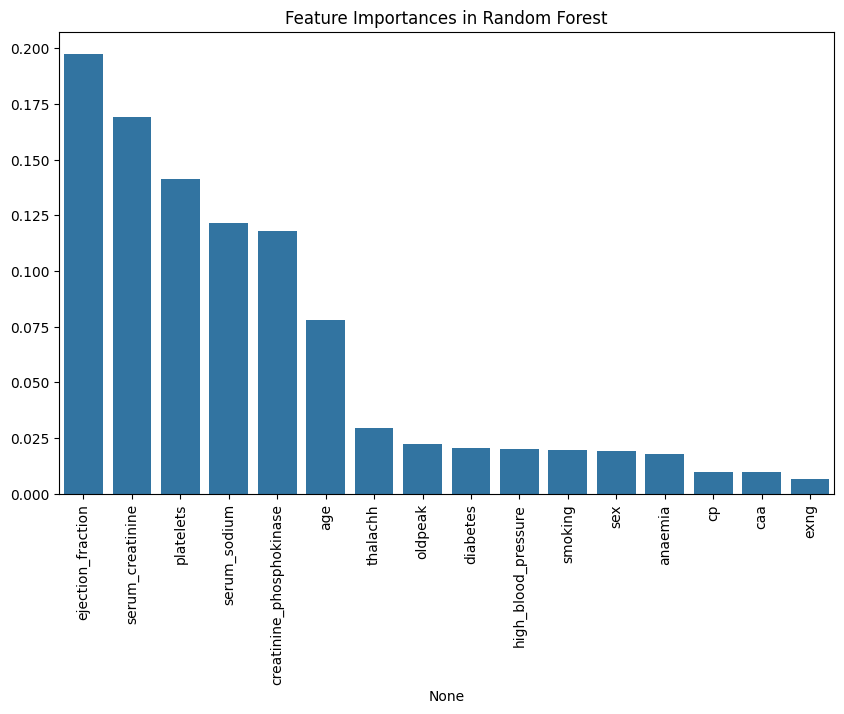

In [31]:
# Візуалізація важливості ознак у Random Forest
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]
X_columns_sorted = X.columns[indices][:len(importances)]

plt.figure(figsize=(10, 6))
sns.barplot(x=X_columns_sorted, y=importances[indices])
plt.title('Feature Importances in Random Forest')
plt.xticks(rotation=90)
plt.show()